In [16]:
import os
import talib
import numpy as np
import pandas as pd
import mpl_finance as mpf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def plot_whole_picture(stock_df, broker_df, hl_dates=[]):    
    broker_df.loc[:, '賣出股數'] = broker_df['賣出股數'] * (-1)
    daily_summary = broker_df.groupby('日期').agg(sell=('賣出股數', 'sum'), buy=('買進股數', 'sum')).reset_index()
    daily_summary.loc[:, '買超'] = daily_summary['buy'] + daily_summary['sell']
    daily_summary.loc[:, '買超'] = daily_summary['買超'].map(lambda x: 0 if x < 0 else x)
    daily_summary.loc[:, '賣超'] = daily_summary['buy'] + daily_summary['sell']
    daily_summary.loc[:, '賣超'] = daily_summary['賣超'].map(lambda x: 0 if x > 0 else x)

    stock_df = stock_df[(stock_df['日期']<=daily_summary['日期'].max()) & (stock_df['日期']>=daily_summary['日期'].min())]
    daily_date_list = set(stock_df['日期'].to_list())

    broker_date_list = set(daily_summary['日期'].to_list())

    idle_date_list = daily_date_list - broker_date_list
    idle_data = []
    for date in idle_date_list:
        data = dict()
        data['日期'] = date
        data['buy'] = 0
        data['sell'] = 0
        idle_data.append(data)
    filled_daily_summary = daily_summary.append(pd.DataFrame(idle_data))
    filled_daily_summary = filled_daily_summary.sort_values('日期')

    sma_5 = talib.SMA(np.array(stock_df['收盤價']), 5)
    sma_20 = talib.SMA(np.array(stock_df['收盤價']), 20)

    fig = plt.figure(figsize=(15, 6))

    ax1 = fig.add_axes([0,0.5,1,0.5])
    ax2 = fig.add_axes([0,0.25,1,0.25])
    ax3 = fig.add_axes([0,0,1,0.25])

    ax1.grid(lw=1, ls="--")
    ax1.xaxis.set_tick_params(rotation=90)
    ax1.set_xticks(range(0, len(stock_df.index)))

    ax2.grid(lw=1, ls="--")
    ax2.xaxis.set_tick_params(rotation=90)
    ax2.set_xticks(range(0, len(filled_daily_summary.index)))

    ax3.grid(lw=1, ls="--")
    ax3.xaxis.set_tick_params(rotation=90)
    ax3.set_xticks(range(0, len(filled_daily_summary.index)))
    ax3.set_xticklabels([dt.strftime('%Y-%m-%d') for dt in filled_daily_summary['日期']]) 

    ax1.get_shared_x_axes().join(ax1, ax3)
    ax1.plot(sma_5, label='5日均線')
    ax1.plot(sma_20, label='20日均線')
    mpf.candlestick2_ochl(ax1, stock_df['開盤價'], stock_df['收盤價'], stock_df['最高價'],stock_df['最低價'], width=0.5, colorup='r', colordown='g', alpha=0.75)
    mpf.volume_overlay(ax2, filled_daily_summary['buy'], filled_daily_summary['buy'], filled_daily_summary['buy'], colorup='r', colordown='r', width=0.5, alpha=0.7)
    mpf.volume_overlay(ax2, filled_daily_summary['sell'], filled_daily_summary['sell'], filled_daily_summary['sell'], colorup='g', colordown='g', width=0.5, alpha=0.7)
    mpf.volume_overlay(ax3, filled_daily_summary['買超'], filled_daily_summary['買超'], filled_daily_summary['買超'], colorup='r', colordown='r', width=0.5, alpha=0.7)
    mpf.volume_overlay(ax3, filled_daily_summary['賣超'], filled_daily_summary['賣超'], filled_daily_summary['賣超'], colorup='g', colordown='g', width=0.5, alpha=0.7)

    grid_lines = ax1.get_xgridlines()
    ticks_labels = ax3.get_xticklabels()    
    for i in range(len(ticks_labels)):
         if ticks_labels[i]._text in hl_dates:
            line = grid_lines[i]
            line.set_linestyle('-')
            line.set_color('black')
            line.set_alpha(0.15)
            line.set_linewidth(18)

In [3]:
def toNumeric(x):
    try:
        return float(str(x).replace(',', ''))
    except:
        return -1
    
def strToFloat(pdf, num_cols):
    tmp = pdf.copy()
    for col in num_cols:
        tmp.loc[:, col] = tmp[col].apply(toNumeric)
    return tmp

In [99]:
root_path = "C:\\Users\\Fang\\PycharmProjects\\股票分析\\stock_data"
stock_df = pd.read_csv(root_path + os.sep + 'basic_data' + os.sep + '2330.csv', engine='python')
stock_df = strToFloat(stock_df, ["成交股數","成交金額","開盤價","最高價","最低價","收盤價","漲跌價差","漲跌幅","成交筆數"])
stock_df.loc[:,'日期'] = pd.to_datetime(stock_df.loc[:,'日期'])

broker_df = pd.read_csv(root_path + os.sep + 'bs_data' + os.sep + '2330.csv', encoding='utf-8', engine='python')
broker_df = pd.read_csv(root_path + os.sep + 'bs_data' + os.sep + '2330.csv', encoding='utf-8', engine='python')
broker_df = strToFloat(broker_df, ["價格", "買進股數", "賣出股數"])
broker_df.loc[:,'日期'] = pd.to_datetime(broker_df.loc[:,'日期'])

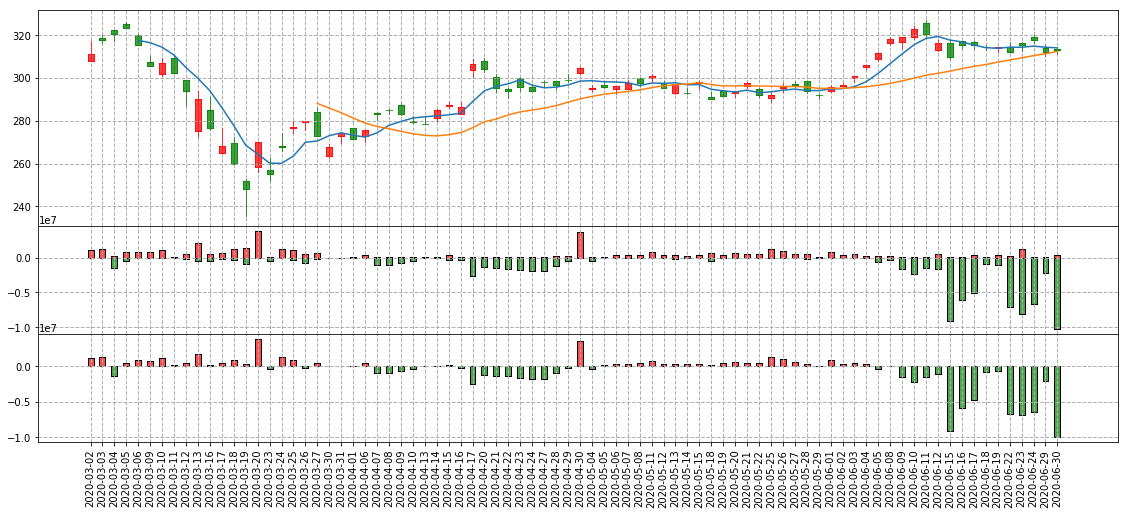

In [27]:
stock_df = stock_df[stock_df['日期']>'2020-03-01']
broker_df = broker_df[broker_df['日期']>'2020-03-01']
plot_whole_picture(stock_df, broker_df[broker_df['券商']=='5920'])

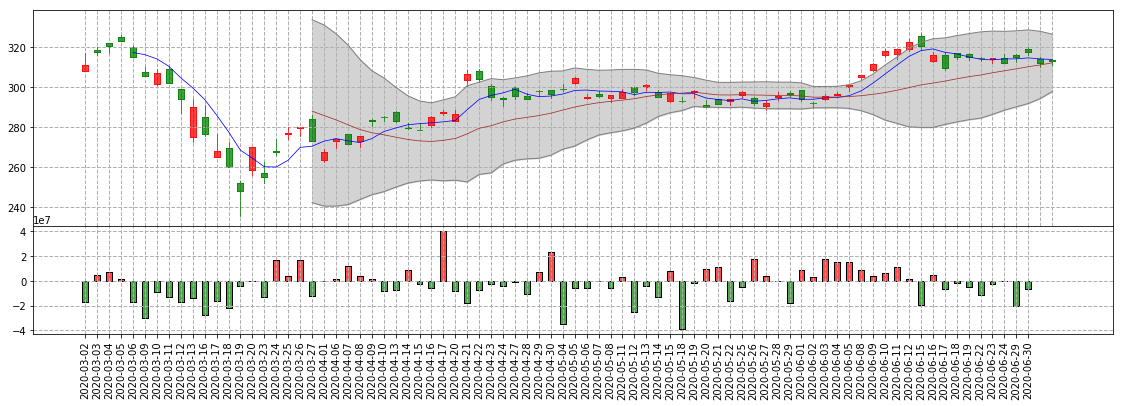

In [105]:
broker_df = broker_df[broker_df['日期']>'2020-03-01']
stock_df = stock_df[stock_df['日期']>'2020-03-01']
stock_df = stock_df[(stock_df['日期']<=broker_df['日期'].max()) & (stock_df['日期']>=broker_df['日期'].min())]

sma_5 = talib.SMA(np.array(stock_df['收盤價']), 5)
sma_20 = talib.SMA(np.array(stock_df['收盤價']), 20)
closed = stock_df['收盤價'].values
upper,middle,lower = talib.BBANDS(closed,20, 2, 2, matype=talib.MA_Type.SMA)

fig = plt.figure(figsize=(15, 6))

ax1 = fig.add_axes([0,0.5,1,0.5])
ax2 = fig.add_axes([0,0.25,1,0.25])

ax1.grid(lw=1, ls="--")
ax1.xaxis.set_tick_params(rotation=90)
ax1.set_xticks(range(0, len(stock_df.index)))

ax2.grid(lw=1, ls="--")
ax2.xaxis.set_tick_params(rotation=90)
ax2.set_xticks(range(0, len(buySellDiffDf.index)))
ax2.set_xticklabels([dt.strftime('%Y-%m-%d') for dt in buySellDiffDf['日期']])

broker_df.loc[:, '賣出股數'] = broker_df['賣出股數'] * (-1)
daily_summary = broker_df.groupby(['日期', '券商']).agg(sell=('賣出股數', 'sum'), buy=('買進股數', 'sum')).reset_index()
daily_summary.loc[:, '買超'] = daily_summary['buy'] + daily_summary['sell']
daily_summary.loc[:, '買超'] = daily_summary['買超'].map(lambda x: 0 if x < 0 else x)
daily_summary.loc[:, '賣超'] = daily_summary['buy'] + daily_summary['sell']
daily_summary.loc[:, '賣超'] = daily_summary['賣超'].map(lambda x: 0 if x > 0 else x)

topSellerDf = daily_summary.sort_values('賣超').groupby('日期').head(15)
topSellerDf = topSellerDf.groupby('日期').agg({'賣超':'sum'}).reset_index()
topBuyerDf = daily_summary.sort_values('買超', ascending=False).groupby('日期').head(15)
topBuyerDf = topBuyerDf.groupby('日期').agg({'買超':'sum'}).reset_index()
buySellDiffDf = pd.merge(topBuyerDf, topSellerDf, how='left', on=['日期'])
buySellDiffDf.loc[:,'主力買賣超'] = buySellDiffDf['買超'] + buySellDiffDf['賣超']
buySellDiffDf.loc[:,'主力買超'] = buySellDiffDf['主力買賣超'].map(lambda x: 0 if x < 0 else x)
buySellDiffDf.loc[:,'主力賣超'] = buySellDiffDf['主力買賣超'].map(lambda x: 0 if x > 0 else x)

ax1.get_shared_x_axes().join(ax1, ax2)
ax1.plot(sma_5, label='5日均線', linewidth=.75, color='blue', linestyle='-')
ax1.plot(sma_20, label='20日均線', linewidth=.75, color='brown', linestyle='-')
ax1.plot(upper, label='布林上軌', linewidth=1, color='gray')
ax1.plot(lower, label='布林下軌', linewidth=1, color='gray')
ax1.fill_between(range(0, len(stock_df.index)), upper, lower, color='lightgray')
mpf.candlestick2_ochl(ax1, stock_df['開盤價'], stock_df['收盤價'], stock_df['最高價'],stock_df['最低價'], width=0.5, colorup='r', colordown='g', alpha=0.75)

mpf.volume_overlay(ax2, buySellDiffDf['主力買超'], buySellDiffDf['主力買超'], buySellDiffDf['主力買超'], colorup='r', colordown='r', width=0.5, alpha=0.7)
mpf.volume_overlay(ax2, buySellDiffDf['主力賣超'], buySellDiffDf['主力賣超'], buySellDiffDf['主力賣超'], colorup='g', colordown='g', width=0.5, alpha=0.7)


In [113]:
daily_date_list = set(stock_df['日期'].to_list())
broker_date_list = set(buySellDiffDf['日期'].to_list())
idle_date_list = daily_date_list - broker_date_list
idle_date_list

{Timestamp('2020-03-30 00:00:00'), Timestamp('2020-03-31 00:00:00')}

In [104]:
broker_df.loc[:, '賣出股數'] = broker_df['賣出股數'] * (-1)
daily_summary = broker_df.groupby(['日期', '券商']).agg(sell=('賣出股數', 'sum'), buy=('買進股數', 'sum')).reset_index()
daily_summary.loc[:, '買超'] = daily_summary['buy'] + daily_summary['sell']
daily_summary.loc[:, '買超'] = daily_summary['買超'].map(lambda x: 0 if x < 0 else x)
daily_summary.loc[:, '賣超'] = daily_summary['buy'] + daily_summary['sell']
daily_summary.loc[:, '賣超'] = daily_summary['賣超'].map(lambda x: 0 if x > 0 else x)
daily_summary

In [81]:
topSellerDf = daily_summary[daily_summary['日期']=='2020-03-02'].sort_values('賣超').head(15)
topBuyersDf = daily_summary[daily_summary['日期']=='2020-03-02'].sort_values('買超', ascending=False).head(15)
buySellDiff = topBuyersDf['買超'].sum() + topSellerDf['賣超'].sum()
buySellDiff

In [91]:
topSellerDf = daily_summary.sort_values('賣超').groupby('日期').head(15)
topSellerDf = topSellerDf.groupby('日期').agg({'賣超':'sum'}).reset_index()

In [92]:
topSellerDf = daily_summary.sort_values('賣超').groupby('日期').head(15)
topSellerDf = topSellerDf.groupby('日期').agg({'賣超':'sum'}).reset_index()
topBuyerDf = daily_summary.sort_values('買超', ascending=False).groupby('日期').head(15)
topBuyerDf = topBuyerDf.groupby('日期').agg({'買超':'sum'}).reset_index()
buySellDiffDf = pd.merge(topBuyerDf, topSellerDf, how='left', on=['日期'])
buySellDiffDf.loc[:,'主力買賣超'] = buySellDiffDf['買超'] + buySellDiffDf['賣超']
buySellDiffDf.loc[:,'主力買超'] = buySellDiffDf['主力買賣超'].map(lambda x: 0 if x < 0 else x)
buySellDiffDf.loc[:,'主力賣超'] = buySellDiffDf['主力買賣超'].map(lambda x: 0 if x > 0 else x)

fig = plt.figure(figsize=(15, 6))
ax3 = fig.add_axes([0,0.5,1,0.5])
ax3.grid(lw=1, ls="--")
ax3.xaxis.set_tick_params(rotation=90)
ax3.set_xticks(range(0, len(buySellDiffDf.index)))
ax3.set_xticklabels([dt.strftime('%Y-%m-%d') for dt in buySellDiffDf['日期']])

mpf.volume_overlay(ax3, buySellDiffDf['主力買超'], buySellDiffDf['主力買超'], buySellDiffDf['主力買超'], colorup='r', colordown='r', width=0.5, alpha=0.7)
mpf.volume_overlay(ax3, buySellDiffDf['主力賣超'], buySellDiffDf['主力賣超'], buySellDiffDf['主力賣超'], colorup='g', colordown='g', width=0.5, alpha=0.7)


In [95]:
buySellDiffDf = pd.merge(topBuyerDf, topSellerDf, how='left', on=['日期'])
buySellDiffDf.loc[:,'主力買賣超'] = buySellDiffDf['買超'] + buySellDiffDf['賣超']
buySellDiffDf.loc[:,'主力買超'] = buySellDiffDf['主力買賣超'].map(lambda x: 0 if x < 0 else x)
buySellDiffDf.loc[:,'主力賣超'] = buySellDiffDf['主力買賣超'].map(lambda x: 0 if x > 0 else x)

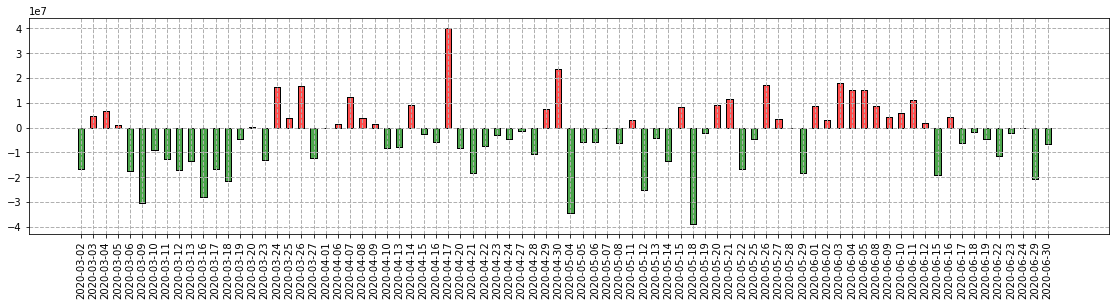

In [96]:
fig = plt.figure(figsize=(15, 6))
ax3 = fig.add_axes([0,0.5,1,0.5])
ax3.grid(lw=1, ls="--")
ax3.xaxis.set_tick_params(rotation=90)
ax3.set_xticks(range(0, len(buySellDiffDf.index)))
ax3.set_xticklabels([dt.strftime('%Y-%m-%d') for dt in buySellDiffDf['日期']])

mpf.volume_overlay(ax3, buySellDiffDf['主力買超'], buySellDiffDf['主力買超'], buySellDiffDf['主力買超'], colorup='r', colordown='r', width=0.5, alpha=0.7)
mpf.volume_overlay(ax3, buySellDiffDf['主力賣超'], buySellDiffDf['主力賣超'], buySellDiffDf['主力賣超'], colorup='g', colordown='g', width=0.5, alpha=0.7)


In [97]:
buySellDiffDf

,日期,買超,賣超,主力買賣超,主力買超,主力賣超
0,2020-03-02,16927937.0,-33682212.0,-16754275.0,0.0,-16754275.0
1,2020-03-03,19040575.0,-14236991.0,4803584.0,4803584.0,0.0
2,2020-03-04,21197126.0,-14431686.0,6765440.0,6765440.0,0.0
3,2020-03-05,14521440.0,-13335790.0,1185650.0,1185650.0,0.0
4,2020-03-06,12337693.0,-29687774.0,-17350081.0,0.0,-17350081.0
...,...,...,...,...,...,...
75,2020-06-22,9702631.0,-21164374.0,-11461743.0,0.0,-11461743.0
76,2020-06-23,18641124.0,-20922356.0,-2281232.0,0.0,-2281232.0
77,2020-06-24,23355543.0,-23581392.0,-225849.0,0.0,-225849.0
78,2020-06-29,10270585.0,-30818347.0,-20547762.0,0.0,-20547762.0
